# SI Prediction — End-to-End Notebook

This notebook includes preprocessing, feature engineering, modeling, SHAP explainability, residual-based anomaly detection, and a Genetic Algorithm optimizer.

Place your dataset at `data/si_data.csv`.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
import joblib
print('libs loaded')

libs loaded


In [2]:
DATA_PATH='data/DataSet.xlsx'
TIME_COL='Timestamp'
TARGET='SI'
assert os.path.exists(DATA_PATH), f"Place your data CSV at {DATA_PATH}"
df=pd.read_excel(DATA_PATH)
df[TIME_COL]=pd.to_datetime(df[TIME_COL])
df=df.sort_values(TIME_COL).reset_index(drop=True)
print('loaded', df.shape)
df.head()

loaded (5704, 25)


,Timestamp,OxEnRa,BlFuPeIn,EnOxFl,CoBlFl,BlMo,BlFuBoGaVo,BlFuBoGaIn,ThCoTe,ToGaPr,...,CoBlTe,HoBlTe,ToTe,BlHu,CoInSeVa,FoSI,HoBl,ToGasP,CoBF,SI
0,2021-05-12 17:56:25,3.691772,17.661523,16941.904350,36.472670,146.285825,7925.957227,81.975757,2210.712256,224.366480,...,212.936183,1087.730999,NaN,13.118669,45.994059,0.481272,1075.254532,221.600735,36.796521,0.479000
1,2021-05-12 17:56:25,3.744628,0.193811,17554.954071,34.087434,161.762571,8049.518860,81.637472,2268.780322,0.005692,...,NaN,2.082851,1.795880,10.353929,1.580861,0.337968,2.110829,0.005584,34.238289,0.312456
2,2021-05-12 18:01:25,3.702922,17.531952,16983.415800,35.526652,NaN,7927.604542,81.534685,2212.091683,224.253433,...,213.641190,1092.204113,155.791347,13.597754,45.995841,0.480590,1086.126125,220.795548,35.678927,0.485000
3,2021-05-12 18:38:31,3.704258,17.787358,16990.589240,34.882208,147.002954,7932.062270,81.259530,2206.561905,224.181494,...,213.790424,1088.005197,158.113898,13.950920,45.997089,0.481913,1102.376863,228.013179,34.680944,0.429000
4,2021-05-12 18:49:02,3.710455,17.845446,17028.062470,34.445766,150.394003,7938.962944,81.105510,2217.517527,224.086884,...,213.517490,1101.989445,161.883438,14.185215,45.997962,NaN,1101.785918,225.502798,34.206146,0.430000


In [3]:
# basic imputation
print('missing before:', df.isnull().sum().sum())
df = df.set_index(TIME_COL).sort_index()
df = df.ffill().bfill()
for c in df.columns:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].median())
df = df.reset_index()
print('missing after:', df.isnull().sum().sum())

missing before: 4446
missing after: 0


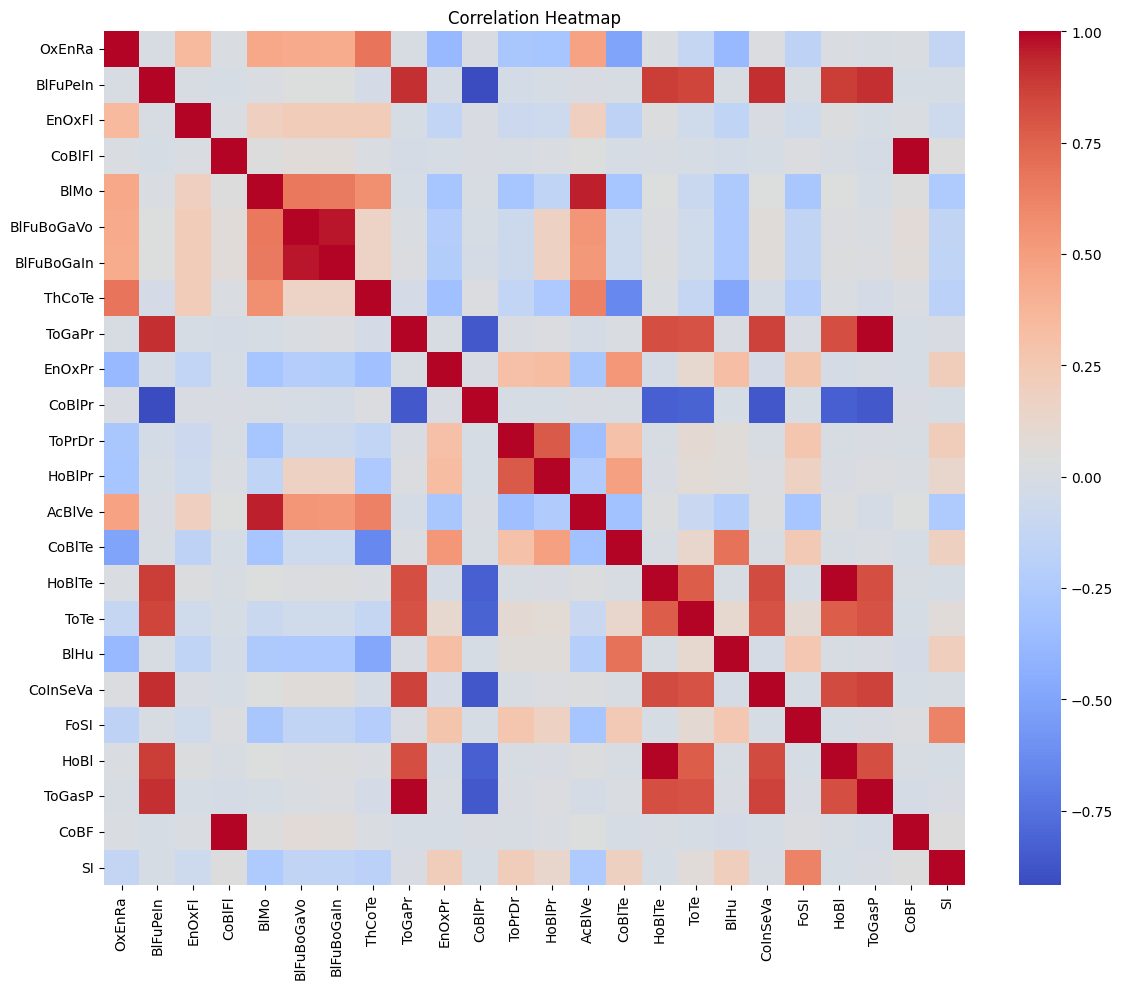

In [4]:
# 3. Correlation heatmap (for numeric columns)
import seaborn as sns
plt.figure(figsize=(12,10))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [5]:
y = df["SI"]
X = df.drop(columns=["SI","Timestamp"], errors="ignore")
feature_stats = {c: {"median": float(df[c].median()), "mean": float(df[c].mean()), "std": float(df[c].std())} for c in X.columns}
with open("models/feature_stats.json","w") as f:
    json.dump(feature_stats,f,indent=2)

In [6]:
NUMERIC_COLS = ['OxEnRa','BlFuPeIn','EnOxFl','CoBlFl','BlMo','BlFuBoGaVo','BlFuBoGaIn','ThCoTe','ToGaPr','EnOxPr','CoBlPr','ToPrDr','HoBlPr','AcBlVe','CoBlTe','HoBlTe','ToTe','BlHu','CoInSeVa','FoSI','HoBl','ToGasP','CoBF']
NUMERIC_COLS = [c for c in NUMERIC_COLS if c in df.columns]
print('using', len(NUMERIC_COLS), 'numeric cols')

def add_time_feats(d):
    d['hour']=d[TIME_COL].dt.hour
    d['dayofweek']=d[TIME_COL].dt.dayofweek
    d['month']=d[TIME_COL].dt.month
    return d

df = add_time_feats(df)

def add_lags_rolls(d, cols, lags=(1,2,3), windows=(3,6,12)):
    dd = d.copy()
    for c in cols:
        for L in lags:
            dd[f'{c}_lag{L}'] = dd[c].shift(L)
        for w in windows:
            dd[f'{c}_r{w}_mean'] = dd[c].rolling(window=w, min_periods=1).mean()
            dd[f'{c}_r{w}_std'] = dd[c].rolling(window=w, min_periods=1).std()
    return dd

df = add_lags_rolls(df, NUMERIC_COLS)
print('shape after features', df.shape)
df = df.dropna().reset_index(drop=True)
print('after dropna', df.shape)

using 23 numeric cols
shape after features (5704, 235)
after dropna (5701, 235)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5701 entries, 0 to 5700
Columns: 235 entries, Timestamp to CoBF_r12_std
dtypes: datetime64[ns](1), float64(231), int32(3)
memory usage: 10.2 MB


In [8]:
from sklearn.impute import KNNImputer
import joblib

# Remove time columns for imputer training
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]
df_numeric = df_numeric.drop(columns=["SI"], errors="ignore")  # drop target if present
print('numeric df shape for imputer:', df_numeric.shape)
# Fit KNN imputer on numeric columns only
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(df_numeric)

# Save the fitted imputer for use in app.py
joblib.dump(knn_imputer, 'models/knn_imputer.joblib')
print('KNN imputer model saved to models/knn_imputer.joblib')

numeric df shape for imputer: (5701, 233)
KNN imputer model saved to models/knn_imputer.joblib


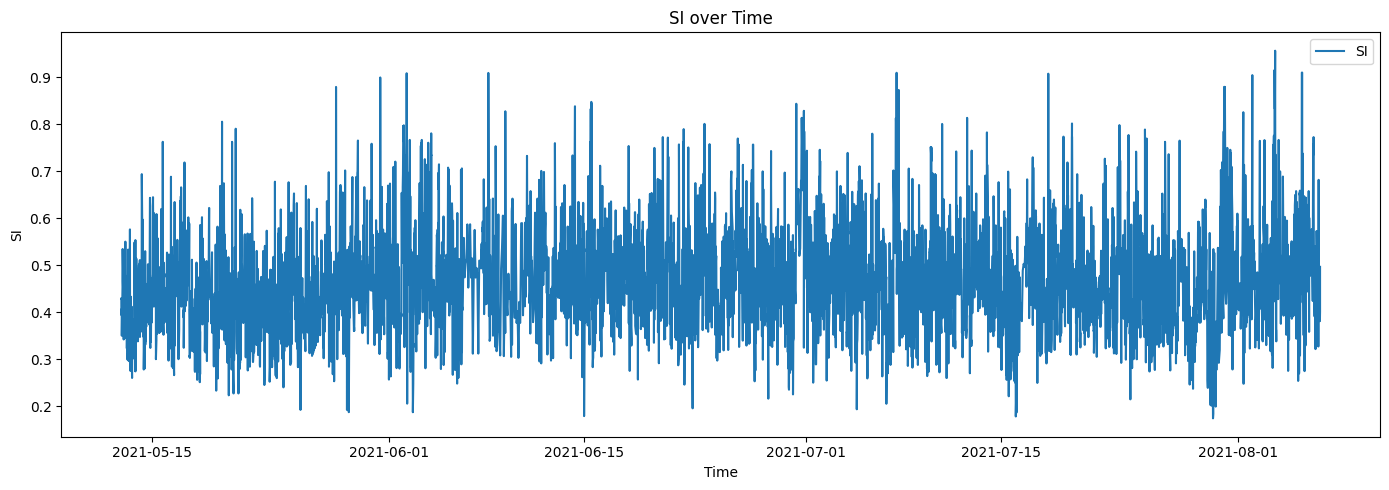

In [9]:
import matplotlib.pyplot as plt

# 1. Plot the target variable over time
plt.figure(figsize=(14,5))
plt.plot(df[TIME_COL], df[TARGET], label='SI')
plt.xlabel('Time')
plt.ylabel('SI')
plt.title('SI over Time')
plt.legend()
plt.tight_layout()
plt.show()

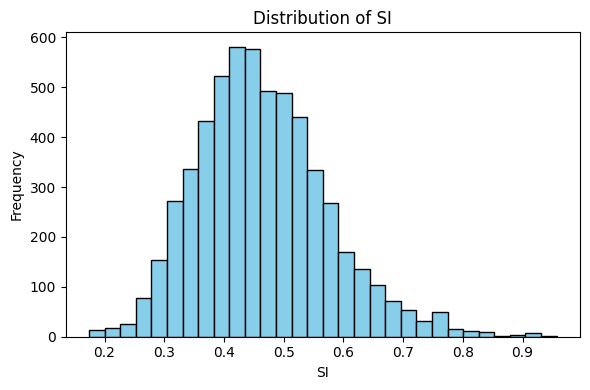

In [10]:
# 2. Histogram of the target variable
plt.figure(figsize=(6,4))
plt.hist(df[TARGET], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('SI')
plt.ylabel('Frequency')
plt.title('Distribution of SI')
plt.tight_layout()
plt.show()


In [11]:
# time-aware split
TEST_HOURS=168
VALID_HOURS=168
max_time = df[TIME_COL].max()
test_start = max_time - pd.Timedelta(hours=TEST_HOURS)
valid_start = test_start - pd.Timedelta(hours=VALID_HOURS)
train_df = df[df[TIME_COL] < valid_start].copy()
valid_df = df[(df[TIME_COL] >= valid_start) & (df[TIME_COL] < test_start)].copy()
test_df = df[df[TIME_COL] >= test_start].copy()
print(train_df.shape, valid_df.shape, test_df.shape)

(4814, 235) (448, 235) (439, 235)


In [12]:
FEATURES = [c for c in train_df.columns if c not in [TIME_COL, TARGET]]
X_train = train_df[FEATURES]; y_train = train_df[TARGET]
X_valid = valid_df[FEATURES]; y_valid = valid_df[TARGET]
X_test = test_df[FEATURES]; y_test = test_df[TARGET]
print('features:', len(FEATURES))

features: 233


In [13]:
# train simple baselines
from sklearn.metrics import r2_score, root_mean_squared_error
lr = LinearRegression(); lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('LR R2, RMSE:', r2_score(y_test, y_pred_lr), root_mean_squared_error(y_test, y_pred_lr))
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42); rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('RF R2, RMSE:', r2_score(y_test, y_pred_rf), root_mean_squared_error(y_test, y_pred_rf))


LR R2, RMSE: 0.38197618444306924 0.09857964485616703
RF R2, RMSE: 0.3524088477306867 0.10091020699459491


In [17]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
xgb = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, n_jobs=-1, random_state=42)
xgb.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
y_pred_xgb = xgb.predict(X_test)

def metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100
    return {'R2': r2, 'RMSE': rmse, 'MAPE': mape}

print('XGB metrics:', metrics(y_test.values, y_pred_xgb))
joblib.dump(xgb, 'models/model_xgb.joblib')

XGB metrics: {'R2': 0.39320820764378994, 'RMSE': 0.09767973947819801, 'MAPE': np.float64(14.30678710284817)}


['models/model_xgb.joblib']

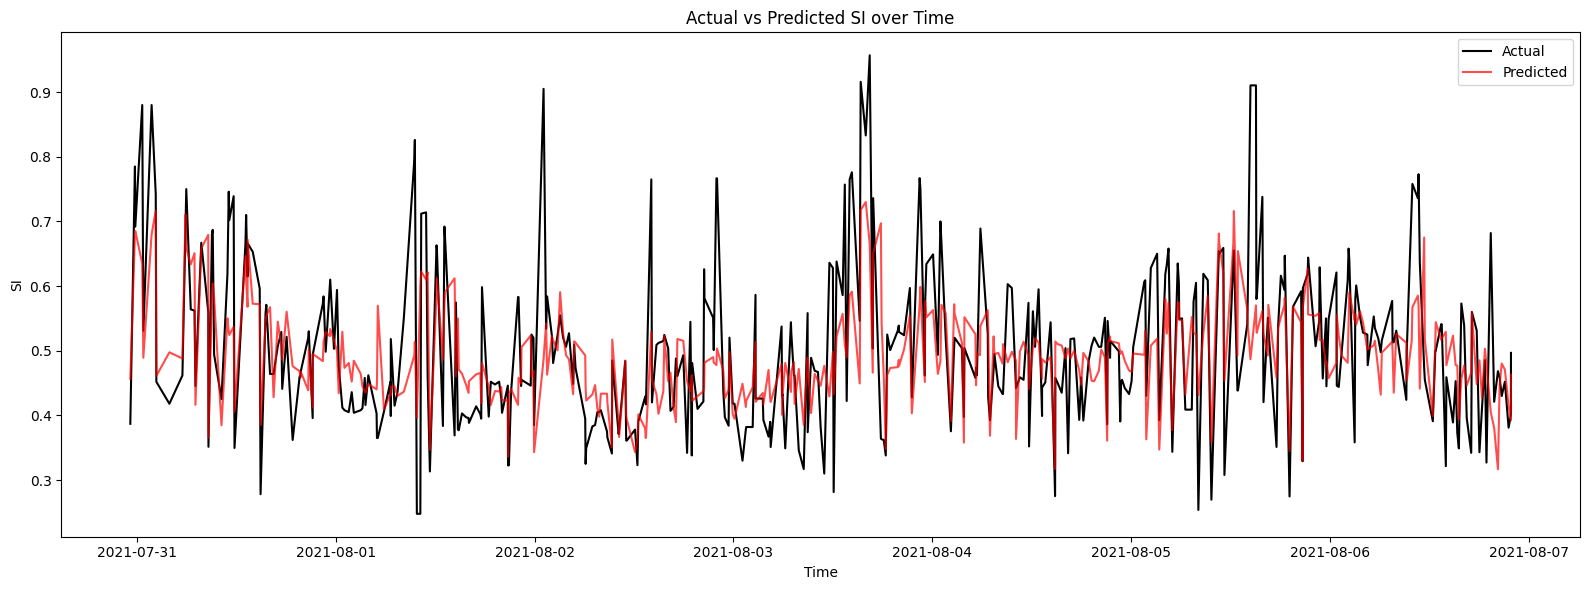

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(test_df[TIME_COL], y_test.values, label='Actual', color='black')
plt.plot(test_df[TIME_COL], y_pred_xgb, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('SI')
plt.title('Actual vs Predicted SI over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Uncertainty via quantile GBM
from sklearn.ensemble import GradientBoostingRegressor
low_q = GradientBoostingRegressor(loss='quantile', alpha=0.1, n_estimators=300, max_depth=3, learning_rate=0.05)
high_q = GradientBoostingRegressor(loss='quantile', alpha=0.9, n_estimators=300, max_depth=3, learning_rate=0.05)
low_q.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
high_q.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
y_low = low_q.predict(X_test)
y_high = high_q.predict(X_test)
joblib.dump(low_q, 'models/model_q_low.joblib')
joblib.dump(high_q, 'models/model_q_high.joblib')
print('quantiles saved')

quantiles saved


,feature,mean_abs_shap
19,FoSI,0.059357
2,EnOxFl,0.003695
6,BlFuBoGaIn,0.003651
186,BlHu_r12_mean,0.003427
7,ThCoTe,0.003390
132,ToPrDr_r12_mean,0.002441
23,hour,0.002340
17,BlHu,0.002337
4,BlMo,0.002320
96,ThCoTe_r12_mean,0.002256


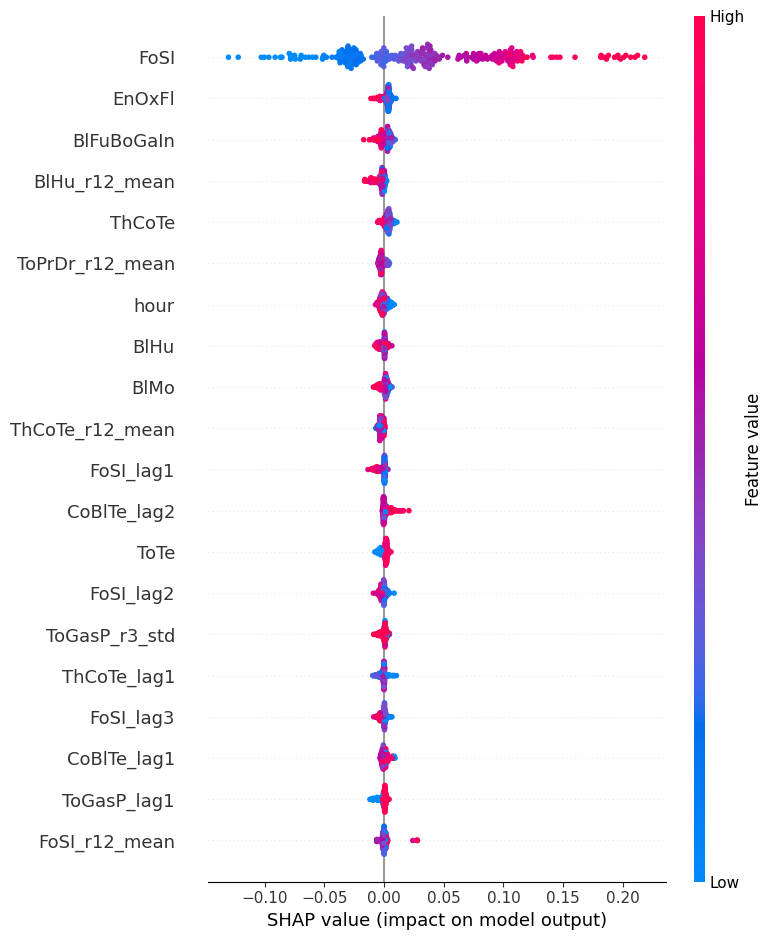

In [20]:
# SHAP explainability
try:
    import shap
    explainer = shap.Explainer(xgb)
    X_sample = X_test.sample(min(300, len(X_test)), random_state=42)
    sv = explainer(X_sample)
    shap.summary_plot(sv, X_sample, show=False)
    plt.tight_layout(); plt.savefig('models/shap_summary.png', dpi=200)
    import numpy as _np
    mean_abs_shap = _np.abs(sv.values).mean(axis=0)
    fi = pd.DataFrame({'feature': X_sample.columns, 'mean_abs_shap': mean_abs_shap}).sort_values('mean_abs_shap', ascending=False)
    display(fi.head(30))
except Exception as e:
    print('SHAP failed, fallback to permutation importance', e)
    from sklearn.inspection import permutation_importance
    pi = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    fi = pd.DataFrame({'feature': X_test.columns, 'importance': pi.importances_mean}).sort_values('importance', ascending=False)
    display(fi.head(30))

In [21]:
# Residual-based anomaly detection
resid = y_test.values - y_pred_xgb
iso = IsolationForest(contamination=0.02, random_state=42); iso.fit(resid.reshape(-1,1))
scores = iso.decision_function(resid.reshape(-1,1)); labels = iso.predict(resid.reshape(-1,1))
report = X_test.copy(); report['SI_true'] = y_test.values; report['SI_pred'] = y_pred_xgb; report['residual'] = resid; report['iforest_score'] = scores; report['is_anomaly'] = (labels == -1).astype(int)
report.to_csv('models/anomaly_report.csv', index=False)
joblib.dump(iso, 'models/iforest_features.joblib')
print('anomalies:', report['is_anomaly'].sum())

anomalies: 9


In [22]:
# Root-cause for anomalies (using SHAP local values if available)
anom_rows = report[report['is_anomaly']==1]
if len(anom_rows) > 0 and 'sv' in globals():
    X_anom = X_test.loc[anom_rows.index]
    sv_local = explainer(X_anom)
    import numpy as _np
    out = []
    for i, idx in enumerate(X_anom.index):
        vals = sv_local.values[i]
        top_idx = _np.argsort(-_np.abs(vals))[:5]
        out.append({'index': int(idx), 'top_drivers': list(X_anom.columns[top_idx])})
    pd.DataFrame(out).to_csv('models/anomaly_root_causes.csv', index=False)
    print('saved anomaly_root_causes.csv')
else:
    print('no anomalies or shap not available')

saved anomaly_root_causes.csv


In [23]:
# Genetic Algorithm optimizer (surrogate-based search using xgb model)
from copy import deepcopy
BOUNDS = {'OxEnRa':(0,10),'BlMo':(5,20),'ThCoTe':(1800,2400),'EnOxFl':(0,30000),'CoInSeVa':(0,1000)}

def random_candidate():
    return {k: float(np.random.uniform(v[0], v[1])) for k,v in BOUNDS.items()}

def candidate_to_df(cand):
    med = X_train.median()
    row = med.copy()
    for k,v in cand.items():
        if k in row.index:
            row[k] = v
    return pd.DataFrame([row.values], columns=row.index)

def evaluate(model, cand, target_si=None):
    df_c = candidate_to_df(cand)
    pred = float(model.predict(df_c)[0])
    if target_si is None:
        return abs(pred - np.median(y_train))
    return abs(pred - target_si)

def crossover(a,b,p=0.5):
    child = {}
    for k in BOUNDS.keys():
        child[k] = a[k] if np.random.rand() < p else b[k]
    return child

def mutate(a, rate=0.2):
    out = deepcopy(a)
    for k,(lo,hi) in BOUNDS.items():
        if np.random.rand() < rate:
            span = hi-lo
            out[k] = float(np.clip(out[k] + np.random.randn()*0.05*span, lo, hi))
    return out

def genetic_search(model, population=30, generations=10, crossover_prob=0.8, mutation_prob=0.2, target_si=None):
    pop = [random_candidate() for _ in range(population)]
    for g in range(generations):
        scores = np.array([evaluate(model, c, target_si) for c in pop])
        order = np.argsort(scores)
        pop = [pop[i] for i in order]
        next_pop = pop[:max(2,population//5)]
        while len(next_pop) < population:
            a, b = np.random.choice(pop[:max(2,population//2)], size=2, replace=False)
            child = crossover(a.copy(), b.copy())
            if np.random.rand() < mutation_prob:
                child = mutate(child)
            next_pop.append(child)
        pop = next_pop
    best = pop[0]
    best_score = evaluate(model, best, target_si)
    return best, best_score

best, score = genetic_search(xgb, population=30, generations=10, target_si=float(np.median(y_train)))
print('GA best:', best, 'score:', score)
pd.DataFrame([best]).to_csv('models/ga_best_setpoint.csv', index=False)

GA best: {'OxEnRa': 0.486059680863965, 'BlMo': 18.48390491427176, 'ThCoTe': 2266.8360334382783, 'EnOxFl': 28859.27463297316, 'CoInSeVa': 915.5513337339846} score: 0.011485062653894151


In [24]:
os.makedirs('models', exist_ok=True)
joblib.dump(xgb, 'models/model_xgb.joblib')
pd.DataFrame([metrics(y_test.values, y_pred_xgb)]).to_csv('models/test_metrics.csv', index=False)
print('saved artifacts')

saved artifacts
